<a href="https://colab.research.google.com/github/Hyshubham2504/Clustering-Project/blob/main/Clustering_Stocks_3_Approaches_OLD_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Import libraries**

In [ ]:
# For getting data
import yfinance as yf
from bs4 import BeautifulSoup as bs
import requests

# For handling data
import pandas as pd
import numpy as np
from datetime import datetime

# For clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# For hyperparameter tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, make_scorer, davies_bouldin_score, calinski_harabasz_score, pairwise_distances

# For data visualization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

#**2. Get the latest list of S&P 500 companies from Slickcharts**

In [ ]:
# Get the latest S&P 500 components symbols (list of companies' ticker symbols)
# Reference: https://www.reddit.com/r/algotrading/comments/mtgakn/free_api_to_get_up_to_date_list_of_all_sp_500/
url = 'https://www.slickcharts.com/sp500'
request = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
soup = bs(request.text, "lxml")
stats = soup.find('table',class_='table table-hover table-borderless table-sm')

df =pd.read_html(str(stats))[0]

SP500_tickers = df['Symbol']

<ipython-input-2-d6f52dca348c>:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df =pd.read_html(str(stats))[0]


In [ ]:
# Check if we got the ticker symbol correctly
print(SP500_tickers.head(), "\n")
print(SP500_tickers.describe())

0    AAPL
1    MSFT
2    NVDA
3    AMZN
4    META
Name: Symbol, dtype: object 

count      503
unique     503
top       AAPL
freq         1
Name: Symbol, dtype: object


#**3. Get the daily return data of the 500 companies and market data (S&P 500 data) from Yahoo Finance**
For the 20-year period 2004-01-01 — 2024-01-01 (YYYY-MM-dd).

In [ ]:
# Temporary fix: Yahoo Finance uses "BRK-B" instead of "BRK.B" and "BF-B" instead of "BF.B"
# Replace these 2 tickers in the SP500_tickers list so that we can get their data from Yahoo Finance
SP500_tickers = list(map(lambda x: x.replace('BRK.B', 'BRK-B'), SP500_tickers))
SP500_tickers = list(map(lambda x: x.replace('BF.B', 'BF-B'), SP500_tickers))

In [ ]:
# This may take 3-4 minutes
start = datetime.now()
SP500_dict = {}

for ticker in SP500_tickers:
    ticker_yahoo = yf.Ticker(ticker)
    adj_close_data = ticker_yahoo.history(start="2004-01-01", end="2024-01-01", auto_adjust=False, actions=False)["Adj Close"]
    if not adj_close_data.empty:
        SP500_dict[ticker] = adj_close_data.pct_change().dropna()

# See how long this piece of code actually took out of curiosity
print(datetime.now() - start)

ERROR:yfinance:GEV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200
ERROR:yfinance:SW: Data doesn't exist for startDate = 1072933200, endDate = 1704085200
ERROR:yfinance:SOLV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200


0:03:04.887862


In [ ]:
sp500_yahoo = yf.Ticker("^GSPC")
sp500_adj_close_data = sp500_yahoo.history(start="2004-01-01", end="2024-01-01", auto_adjust=False, actions=False)["Adj Close"]
sp500_return = sp500_adj_close_data.pct_change().dropna()

# See how long this piece of code actually took out of curiosity
len(sp500_return)

5032

In [ ]:
# Saving the data
# daily_return_df = pd.DataFrame(SP500_dict)
# daily_return_df.to_csv('daily_return_df.csv')

# Loading the dataset from GDrive
import gdown
file_id = '1Ez4YvElmPaAhJ4-Emkuxq21-LLbamVKG'
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file to your local environment
output = 'file.csv'
gdown.download(url, output, quiet=False)

# Read the CSV file using pandas
daily_return_df = pd.read_csv(output, index_col = 0)
daily_return_df.head()

Downloading...
From: https://drive.google.com/uc?id=1Ez4YvElmPaAhJ4-Emkuxq21-LLbamVKG
To: /content/file.csv
100%|██████████| 49.3M/49.3M [00:00<00:00, 72.2MB/s]


,AAPL,MSFT,NVDA,AMZN,META,GOOGL,GOOG,BRK-B,LLY,AVGO,...,DVA,NCLH,ETSY,BIO,RL,AAL,BEN,PARA,FOX,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-05 00:00:00-05:00,0.041824,0.025137,0.032496,0.026397,NaN,NaN,NaN,0.010703,-0.014739,NaN,...,0.011136,NaN,NaN,-0.002739,0.009412,NaN,0.016670,NaN,NaN,NaN
2004-01-06 00:00:00-05:00,-0.003609,0.003553,0.040709,-0.004505,NaN,NaN,NaN,0.008825,-0.000855,NaN,...,-0.012265,NaN,NaN,-0.002575,0.002762,NaN,-0.001131,NaN,NaN,NaN
2004-01-07 00:00:00-05:00,0.022635,-0.001062,0.008869,-0.021309,NaN,NaN,NaN,0.005598,-0.004420,NaN,...,-0.004055,NaN,NaN,0.011876,-0.012741,NaN,0.012830,NaN,NaN,NaN
2004-01-08 00:00:00-05:00,0.034086,-0.001773,0.003597,-0.031985,NaN,NaN,NaN,-0.013222,-0.024635,NaN,...,-0.006870,NaN,NaN,-0.005783,-0.001744,NaN,0.007266,NaN,NaN,NaN
2004-01-09 00:00:00-05:00,-0.015412,-0.017756,0.014337,0.026871,NaN,NaN,NaN,0.006700,-0.007637,NaN,...,-0.002306,NaN,NaN,0.005304,-0.022362,NaN,-0.006288,NaN,NaN,NaN


#**4. Double check the data**

In [ ]:
# A quick look at the descriptive statistics
descriptive_data = daily_return_df.describe()
descriptive_data

,AAPL,MSFT,NVDA,AMZN,META,GOOGL,GOOG,BRK-B,LLY,AVGO,...,DVA,NCLH,ETSY,BIO,RL,AAL,BEN,PARA,FOX,NWS
count,5032.000000,5032.000000,5032.000000,5032.000000,2922.000000,4874.000000,4874.000000,5032.000000,5032.000000,3624.000000,...,5032.000000,2755.000000,2192.000000,5032.000000,5032.000000,4595.000000,5032.000000,4547.000000,1209.000000,2651.000000
mean,0.001487,0.000758,0.001600,0.001101,0.001082,0.001011,0.001014,0.000457,0.000662,0.001505,...,0.000577,0.000554,0.001178,0.000514,0.000644,0.000792,0.000458,0.000367,-0.000008,0.000407
std,0.020802,0.017031,0.030844,0.024294,0.025280,0.019349,0.019367,0.013367,0.015634,0.022169,...,0.018072,0.035391,0.038176,0.018676,0.023349,0.041707,0.021777,0.028343,0.021045,0.018604
min,-0.179195,-0.147391,-0.352336,-0.218220,-0.263901,-0.116342,-0.116091,-0.109440,-0.123483,-0.199129,...,-0.270904,-0.357951,-0.283411,-0.167247,-0.221617,-0.303595,-0.152757,-0.283530,-0.104065,-0.145522
25%,-0.008436,-0.007239,-0.013788,-0.010354,-0.010045,-0.007991,-0.007862,-0.005608,-0.006769,-0.010267,...,-0.007533,-0.013158,-0.018437,-0.008106,-0.010496,-0.017787,-0.009611,-0.012083,-0.010882,-0.009032
50%,0.001137,0.000401,0.001511,0.000567,0.000999,0.000769,0.000701,0.000170,0.000655,0.001441,...,0.000626,0.000219,0.000000,0.000415,0.000527,0.000000,0.000693,0.000289,-0.000632,0.000000
75%,0.012002,0.008788,0.016473,0.012433,0.012825,0.010137,0.010139,0.006389,0.007805,0.012933,...,0.008560,0.013598,0.020372,0.008629,0.011527,0.017940,0.011021,0.012249,0.010762,0.009424
max,0.139050,0.186047,0.298067,0.269497,0.296115,0.199915,0.199915,0.192641,0.156798,0.158337,...,0.135729,0.421923,0.306001,0.205034,0.198007,0.587361,0.161147,0.307624,0.132469,0.132930


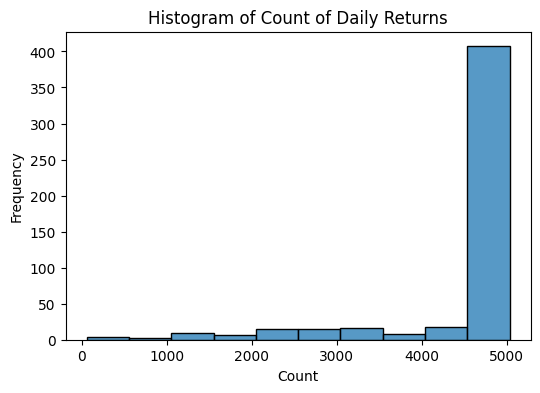

In [ ]:
# A histogram showing how many companies have how many rows of data
# Most of the companies have over 4500 rows of data (in the rightmost bin), so we should have enough daily return data to work with
plt.figure(figsize=(6, 4))
sns.histplot(descriptive_data.loc['count'], bins=10, kde=False)
plt.title('Histogram of Count of Daily Returns')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# We can see that there are 2 companies with no data for this 20-year period (count for 0.0 is 2)
pd.set_option('display.max_rows', None)
descriptive_data.loc['count'].value_counts()

count
5032.0    385
2651.0      2
2370.0      2
4165.0      2
2137.0      2
952.0       2
4874.0      2
2755.0      1
2314.0      1
4651.0      1
2332.0      1
3409.0      1
4658.0      1
4329.0      1
3047.0      1
2203.0      1
3281.0      1
1739.0      1
4306.0      1
4072.0      1
60.0        1
2063.0      1
1885.0      1
1820.0      1
3442.0      1
4223.0      1
3554.0      1
4194.0      1
4710.0      1
3949.0      1
4547.0      1
4642.0      1
2334.0      1
2545.0      1
2444.0      1
4819.0      1
1794.0      1
1429.0      1
3494.0      1
5009.0      1
1210.0      1
2192.0      1
3215.0      1
2263.0      1
2992.0      1
2925.0      1
4535.0      1
4767.0      1
4595.0      1
4186.0      1
4627.0      1
4505.0      1
4792.0      1
4901.0      1
4135.0      1
2956.0      1
2645.0      1
1273.0      1
3287.0      1
2922.0      1
767.0       1
2948.0      1
3149.0      1
3372.0      1
4479.0      1
3223.0      1
4512.0      1
3388.0      1
2746.0      1
2408.0      1
4559.0      1


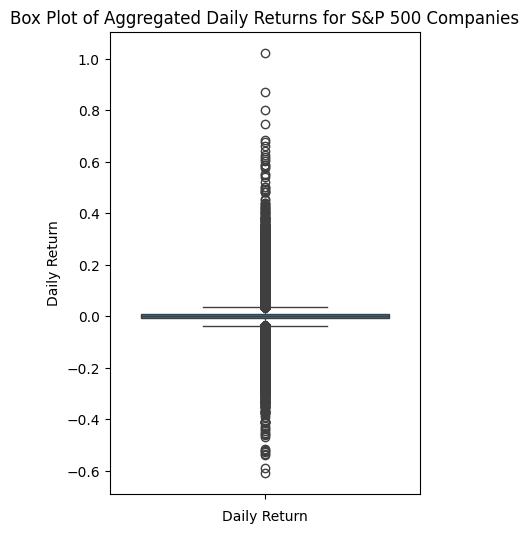

In [ ]:
# How do these daily returns look like in a boxplot?
# It looks pretty normal (not skewed heavily to the left or right)

# aggregated_return: daily returns of all companies combined into one list
aggregated_return = daily_return_df.stack()

plt.figure(figsize=(4, 6))
sns.boxplot(aggregated_return)
plt.title('Box Plot of Aggregated Daily Returns for S&P 500 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Daily Return')
plt.show()

In [ ]:
# What are the minimum and maximum daily returns out of all this data? Out of curiosity..
summary_statistics = aggregated_return.describe()
summary_statistics

count    2.299678e+06
mean     6.895366e-04
std      2.199350e-02
min     -6.079076e-01
25%     -8.533941e-03
50%      6.372738e-04
75%      9.847951e-03
max      1.023579e+00
dtype: float64

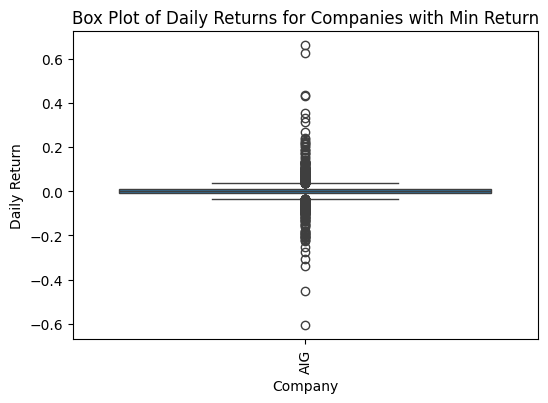

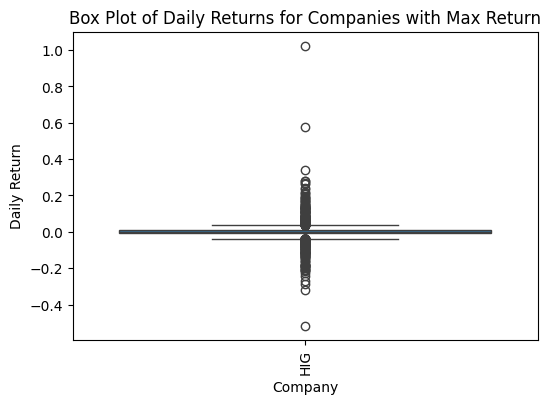

In [ ]:
# What are the companies that achieve the minimum and maximum daily returns?
companies_min = daily_return_df.loc[:, (daily_return_df == summary_statistics['min']).any()].columns
companies_max = daily_return_df.loc[:, (daily_return_df == summary_statistics['max']).any()].columns

plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_min])
plt.title('Box Plot of Daily Returns for Companies with Min Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_max])
plt.title('Box Plot of Daily Returns for Companies with Max Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# When do these companies achieve the minimum and maximum values respectively?
print("For AIG, it achieves the minimum on: ", daily_return_df.index[daily_return_df['AIG'] == summary_statistics['min']])
print("For HIG, it achieves the maximum on: ", daily_return_df.index[daily_return_df['HIG'] == summary_statistics['max']])

For AIG, it achieves the minimum on:  Index(['2008-09-15 00:00:00-04:00'], dtype='object', name='Date')
For HIG, it achieves the maximum on:  Index(['2008-12-05 00:00:00-05:00'], dtype='object', name='Date')


<Figure size 2000x600 with 0 Axes>

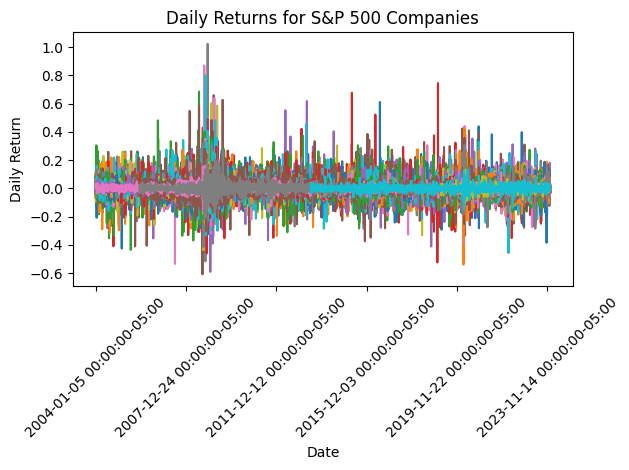

In [ ]:
# The minimum and maximum values are achieved around the end of 2008
# These dates fall within the 2008 financial crisis
# In the line chart below, we can see that during the 2008 financial crisis, daily returns could go very high up and also very low, showing strong volatility
plt.figure(figsize=(20, 6))

daily_return_df.plot(legend=False)
plt.title('Daily Returns for S&P 500 Companies')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#**5. Clean the data and define the different periods**

In [ ]:
# Remove companies that do not have complete data for this 20-year period
# Therefore, as long as a company is missing data for 1 day, it is removed
# Drop stocks (columns, hence axis = 1) with null values within this 10-year period
df = daily_return_df.dropna(axis=1)

# Double check if none of the companies left have missing data
# This should output 0 for all companies
df.isnull().sum()

AAPL     0
MSFT     0
NVDA     0
AMZN     0
BRK-B    0
LLY      0
JPM      0
UNH      0
XOM      0
PG       0
JNJ      0
COST     0
HD       0
WMT      0
MRK      0
NFLX     0
BAC      0
KO       0
CVX      0
ADBE     0
PEP      0
TMO      0
ORCL     0
LIN      0
AMD      0
ACN      0
WFC      0
MCD      0
CSCO     0
ABT      0
GE       0
DHR      0
QCOM     0
AMGN     0
INTU     0
TXN      0
IBM      0
PFE      0
VZ       0
DIS      0
AMAT     0
CAT      0
GS       0
NEE      0
ISRG     0
CMCSA    0
SPGI     0
RTX      0
UNP      0
AXP      0
T        0
LOW      0
HON      0
VRTX     0
TJX      0
MS       0
COP      0
PGR      0
BKNG     0
ELV      0
INTC     0
BLK      0
C        0
ETN      0
PLD      0
LMT      0
REGN     0
SYK      0
MU       0
MMC      0
CB       0
BSX      0
ADI      0
LRCX     0
MDT      0
ADP      0
AMT      0
BA       0
KLAC     0
BMY      0
SO       0
GILD     0
SCHW     0
UPS      0
CI       0
FI       0
DE       0
MDLZ     0
NKE      0
DUK      0
MO       0

In [ ]:
# See how many companies are left after dropping companies with null values
len(df.columns)

385

The first human cases of COVID-19 occurred in Wuhan, People's Republic of China, on or about 17 November 2019.[2] The first human case in the United States was on 21 January 2020. The World Health Organization declared the COVID-19 outbreak a Public Health Emergency of International Concern (PHEIC) on 30 January 2020, and first referred to it as a pandemic on 11 March 2020.[3][4] The WHO ended the PHEIC on 5 May 2023.[5]
https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic

In [ ]:
# Define the different periods
pre_financial_crisis = df.loc['2004-01-01':'2006-12-31']
financial_crisis = df.loc['2007-01-01':'2009-06-30']
post_financial_crisis = df.loc['2009-07-01':'2019-12-31']
covid_period = df.loc['2020-01-01':'2022-12-31']
post_covid_period = df.loc['2023-01-01':]

# Store the periods in a list to iterate through
periods = [pre_financial_crisis, financial_crisis, post_financial_crisis, covid_period, post_covid_period]
period_names = ['pre_financial_crisis', 'financial_crisis', 'post_financial_crisis', 'covid_period', 'post_covid_period']

In [ ]:
five_year_period_names = ['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5']
five_year_periods = [df.loc['2004-01-01':'2008-12-31'], df.loc['2009-01-01':'2013-12-31'], df.loc['2014-01-01':'2018-12-31'], df.loc['2019-01-01':'2023-12-31']]

#**6. Get GICS sector and industry**

In [ ]:
tickers = df.columns.tolist()

# Function to get GICS sector and industry
def get_gics_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        industry = stock.info.get('industry', 'Unknown')
        return sector, industry
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return 'Unknown', 'Unknown'

# Fetch GICS data for each ticker
gics_data = []
for ticker in tickers:
    sector, industry = get_gics_data(ticker)
    gics_data.append({'Company': ticker, 'GICS Sector': sector, 'GICS Industry': industry})

# Convert to DataFrame
gics_df = pd.DataFrame(gics_data)

# Display the GICS DataFrame
print(gics_df)

    Company             GICS Sector                             GICS Industry
0      AAPL              Technology                      Consumer Electronics
1      MSFT              Technology                 Software - Infrastructure
2      NVDA              Technology                            Semiconductors
3      AMZN       Consumer Cyclical                           Internet Retail
4     BRK-B      Financial Services                   Insurance - Diversified
5       LLY              Healthcare              Drug Manufacturers - General
6       JPM      Financial Services                       Banks - Diversified
7       UNH              Healthcare                          Healthcare Plans
8       XOM                  Energy                      Oil & Gas Integrated
9        PG      Consumer Defensive             Household & Personal Products
10      JNJ              Healthcare              Drug Manufacturers - General
11     COST      Consumer Defensive                           Di

In [ ]:
# See how many companies fall into each GICS sector
gics_df['GICS Sector'].value_counts()

GICS Sector
Industrials               57
Healthcare                54
Technology                52
Financial Services        52
Consumer Cyclical         41
Consumer Defensive        31
Utilities                 28
Real Estate               26
Energy                    17
Basic Materials           17
Communication Services    10
Name: count, dtype: int64

In [ ]:
gics_df[gics_df['GICS Sector'] == 'Unknown']

,Company,GICS Sector,GICS Industry


https://www.barchart.com/stocks/quotes/PHM/overview
https://www.barchart.com/stocks/quotes/GPN/overview

PHM: Consumer discretionary / consumer cyclical

GPN: Financials

In [ ]:
gics_df.loc[gics_df['Company'] == 'PHM', 'GICS Sector'] = "Consumer Cyclical"
gics_df.loc[gics_df['Company'] == 'GPN', 'GICS Sector'] = "Financial Services"
gics_df['GICS Sector'].value_counts()

GICS Sector
Industrials               56
Healthcare                54
Financial Services        53
Technology                52
Consumer Cyclical         41
Consumer Defensive        31
Utilities                 28
Real Estate               26
Energy                    17
Basic Materials           17
Communication Services    10
Name: count, dtype: int64

#Note:
- We used to only have GEV and SOLV having no data at all for this 20-year period, but now there's a new one called SW. SW seems to be a very new company (?) according to Yahoo Finance
- Cleaned daily returns dataframe is **df**
- GICS dataframe is **gics_df**
- The different periods are defined in this way:
  - pre_financial_crisis: 2004-01-01 to 2006-12-31
  - financial_crisis: 2007-01-01 to 2009-06-30
  - post_financial_crisis: 2009-07-01 to 2019-12-31
  - covid_period: 2020-01-01 to 2022-12-31
  - post_covid_period: 2023-01-01 onwards
- The market data (S&P 500 data) is **sp500_return**





#**7. First approach: correlation matrix**

##**7.1 Get the correlation matrix**

In [ ]:
# Create a correlation matrix based on the daily return data and considering data until 2022.
correlation_matrix = df.corr()
correlation_matrix

,AAPL,MSFT,NVDA,AMZN,BRK-B,LLY,JPM,UNH,XOM,PG,...,MHK,BBWI,GL,BWA,IVZ,WYNN,DVA,BIO,RL,BEN
AAPL,1.000000,0.515875,0.457382,0.445228,0.366614,0.290833,0.395235,0.342861,0.342901,0.333419,...,0.324032,0.312326,0.363540,0.380447,0.430848,0.358943,0.233430,0.335534,0.335786,0.429875
MSFT,0.515875,1.000000,0.511252,0.513598,0.456937,0.397549,0.449748,0.401533,0.413685,0.443252,...,0.390500,0.333697,0.443546,0.425435,0.490187,0.365627,0.277980,0.400262,0.377421,0.498522
NVDA,0.457382,0.511252,1.000000,0.415434,0.353807,0.263925,0.355184,0.293262,0.318555,0.270191,...,0.353756,0.317734,0.355272,0.401877,0.427254,0.369073,0.234857,0.327366,0.346381,0.424247
AMZN,0.445228,0.513598,0.415434,1.000000,0.331856,0.278473,0.347681,0.288249,0.284269,0.264904,...,0.321843,0.292081,0.308103,0.348607,0.393931,0.329508,0.241217,0.337587,0.334890,0.414686
BRK-B,0.366614,0.456937,0.353807,0.331856,1.000000,0.349592,0.595031,0.403913,0.480735,0.414461,...,0.471732,0.392326,0.602610,0.466948,0.566588,0.420933,0.325926,0.363027,0.426164,0.564983
LLY,0.290833,0.397549,0.263925,0.278473,0.349592,1.000000,0.350960,0.406178,0.365667,0.445080,...,0.272965,0.234130,0.410188,0.270616,0.371833,0.207043,0.284546,0.330183,0.272778,0.394955
JPM,0.395235,0.449748,0.355184,0.347681,0.595031,0.350960,1.000000,0.395930,0.481011,0.398160,...,0.506334,0.432276,0.702855,0.514146,0.676940,0.485510,0.308919,0.381236,0.493901,0.677666
UNH,0.342861,0.401533,0.293262,0.288249,0.403913,0.406178,0.395930,1.000000,0.386971,0.388406,...,0.325199,0.287494,0.422063,0.345585,0.402923,0.288816,0.350190,0.328292,0.314507,0.412052
XOM,0.342901,0.413685,0.318555,0.284269,0.480735,0.365667,0.481011,0.386971,1.000000,0.401539,...,0.384065,0.355068,0.514018,0.448363,0.518655,0.387211,0.292359,0.277691,0.405037,0.527886
PG,0.333419,0.443252,0.270191,0.264904,0.414461,0.445080,0.398160,0.388406,0.401539,1.000000,...,0.301605,0.277221,0.449835,0.316552,0.416589,0.239670,0.295689,0.329197,0.304402,0.448645


In [ ]:
# None of the correlation coefficients are negative which is expected
# as all companies move with the market, which in general is always going up
correlation_matrix[correlation_matrix < 0].stack()

Series([], dtype: float64)

In [ ]:
scaler = StandardScaler()
correlation_matrix_scaled = scaler.fit_transform(correlation_matrix)

###**7.1.1 Attempt to remove market trend (S&P 500 trend) from the daily return data**

In [ ]:
# https://quant.stackexchange.com/questions/75445/detrending-price-series-for-back-testing
import statsmodels.api as sm

residuals = pd.DataFrame(index=df.index, columns=df.columns)

# Perform market model regression for each stock
for stock in df.columns:
    y = df[stock]
    X = sm.add_constant(sp500_return.reindex(y.index))
    model = sm.OLS(y, X).fit()
    residuals[stock] = model.resid

resid_correlation_matrix = residuals.corr()

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(resid_correlation_matrix)

print(np.unique(clusters, return_counts=True))


KeyboardInterrupt: 

##**7.2 K-means clustering**

###**7.2.1 Hyperparameter tuning**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# *****Can take up to 8 minutes
param_grid_kmeans = {
    'n_clusters': range(2, 21),
    'n_init': ['auto', 10, 20, 30],
    'max_iter': [300, 400, 500],
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan'],
}

# In the variable name kmeans_first, I use 'first' to indicate 'first approach'
kmeans_first = KMeans(random_state=123)

# Initialize variables
best_kmeans_first_score = -2    # The lowest that silhouette score can be is -1
best_kmeans_first_grid = None
best_kmeans_first_labels = None

# To keep track of all combinations and their silhouette scores
kmeans_first_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_kmeans):
    kmeans_first.set_params(**g)
    kmeans_first.fit(correlation_matrix)
    kmeans_first_labels = kmeans_first.labels_
    # score = silhouette_score(correlation_matrix, kmeans_first_labels)
    score = silhouette_score(correlation_matrix, kmeans_first_labels)
    kmeans_first_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(kmeans_first_labels, return_counts=True)})

    if score > best_kmeans_first_score:
        best_kmeans_first_score = score
        best_kmeans_first_grid = g
        best_kmeans_first_labels = kmeans_first_labels

print("The best silhouette score is: ", best_kmeans_first_score)
print("The best hyperparameters are: ", best_kmeans_first_grid)
kmeans_first_results_df = pd.DataFrame(kmeans_first_results)

For the record: \

The best silhouette score is:  0.2777784895445786 \

The best hyperparameters are: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 20}
************************************************************************

Update, after removing post covid data: \

The best silhouette score is:  0.27876475685204927

The best hyperparameters are:  {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 20}

In [ ]:
kmeans_first_results_df.sort_values(by='silhouette_score', ascending=False)

In [ ]:
# For the sake of visualization, plot the elbow method graph
# with the best hyperparameter values
n_cluster_options = range(2, 21)

# inertia_: Sum of squared distances of samples to their closest cluster center
inertia_array = []
kmeans_results = {}

for n_cluster in n_cluster_options:
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=20)
    kmeans.fit(correlation_matrix)
    kmeans_labels = kmeans.labels_
    kmeans_results[n_cluster] = kmeans_labels
    inertia_array.append(kmeans.inertia_)

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 595

# Plot elbow method (inertia)
plt.figure(figsize=(8, 6))
plt.plot(n_cluster_options, inertia_array, marker='.')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
plt.plot(x_values, y_values, color='red')
plt.text(n_cluster_options[5], inertia_array[5], f'{n_cluster_options[5]}', ha='right', va='bottom')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters for K-Means')
plt.grid(True)
plt.show()

In [ ]:
n_cluster = 3
pca = PCA(n_components=2)

pca_components = pca.fit_transform(correlation_matrix)

kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='random', max_iter=300, n_init=20)
kmeans.fit(correlation_matrix)
kmeans_labels = kmeans.labels_

plt.figure(figsize=(8, 6))

# Create a colormap
unique_labels_length = len(np.unique(kmeans_labels))
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
colors = cmap(kmeans_labels)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis')

plt.show()

###**7.2.2 Count and percentage of industry sector in each cluster**

In [ ]:
kmeans_first_sector_counts = pd.DataFrame({'Cluster': best_kmeans_first_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
kmeans_first_sector_percentages = kmeans_first_sector_counts.div(kmeans_first_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar chart
ax = kmeans_first_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 3)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
ax = kmeans_first_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 3)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**7.2.3 Count and percentage of cluster in each industry sector**

In [ ]:
# Similar as before, but switch 0 and 1 in "axis="
kmeans_first_cluster_percentages = kmeans_first_sector_counts.div(kmeans_first_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = kmeans_first_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = {n_cluster})')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = kmeans_first_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = {n_cluster})')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**7.2.4 Track Amazon**

In [ ]:
n_cluster = 3
pca = PCA(n_components=2)

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    pca_components = pca.fit_transform(period_correlation_matrix)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=20)
    kmeans.fit(period_correlation_matrix)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the k-means labels
    unique_labels_length = len(np.unique(kmeans_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(kmeans_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = period_correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = kmeans_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

##**7.3 Hierarchical clustering**

###**7.3.1 Hyperparameter tuning**

In [ ]:
# Plot a dendogram to get an idea of the distance
link = linkage(correlation_matrix, method='ward', metric='euclidean')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

NameError: name 'correlation_matrix' is not defined

In [ ]:
# *****
param_grid_hierarchical = {
    'n_clusters': range(2, 21),
    #'linkage': ['ward', 'complete', 'average', 'single'],
    'linkage': ['ward'],
    #'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
    'metric': ['euclidean'],
    #'distance_threshold': [5, 10, 2]
}

#cleaned_correlation_matrix = df.drop(columns=['NEM']).corr()

# In the variable name kmeans_first, I use 'first' to indicate 'first approach'
hierarchical_first = AgglomerativeClustering(n_clusters=None)

# Initialize variables
best_hierarchical_first_score = -2    # The lowest that silhouette score can be is -1
#best_hierarchical_first_score = float('inf')
best_hierarchical_first_grid = None
best_hierarchical_first_labels = None
hierarchical_first_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_hierarchical):
    # Skip invalid combinations
    # ward can only work with euclidean, otherwise it will throw an error
    if g['linkage'] == 'ward' and g['metric'] != 'euclidean':
        continue

    hierarchical_first.set_params(**g)
    hierarchical_first.fit(correlation_matrix)
    hierarchical_first_labels = hierarchical_first.labels_
    score = silhouette_score(correlation_matrix, hierarchical_first_labels)
    #score = davies_bouldin_score(correlation_matrix, hierarchical_first_labels)
    hierarchical_first_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(hierarchical_first_labels, return_counts=True)})

    if score > best_hierarchical_first_score:
    #if score < best_hierarchical_first_score:
        best_hierarchical_first_score = score
        best_hierarchical_first_grid = g
        best_hierarchical_first_labels = hierarchical_first_labels

print("The best silhouette score is: ", best_hierarchical_first_score)
print("The best hyperparameters are: ", best_hierarchical_first_grid)
hierarchical_first_results_df = pd.DataFrame(hierarchical_first_results)

For the record: \

The best silhouette score is:  0.2340130512792354 \

The best hyperparameters are:  {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5}
*******************************************************
After removing post covid:-

The best silhouette score is:  0.23539538077709363

The best hyperparameters are:  {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}

In [ ]:
hierarchical_first_results_df.sort_values(by='silhouette_score', ascending=False)

In [ ]:
def wss_calculation(K, data):
    WSS = []
    for i in range(1, K):
        cluster = AgglomerativeClustering(n_clusters=i + 1)
        labels = cluster.fit_predict(data)
        wss = []
        for j in range(i + 1):
            # extract each cluster according to its index
            cluster_data = data[labels == j]
            cluster_mean = cluster_data.mean(axis=0)
            distance = np.sum(np.square(cluster_data - cluster_mean))
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

WSS = wss_calculation(20, correlation_matrix)

# Test out different values of n_clusters using the elbow method
# Try the numbers between 2 to 20
n_cluster_options = range(2, 21)

silhouette_scores_hierarchical = []
hierarchical_results = {}

for n_cluster in n_cluster_options:
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(correlation_matrix)
    hierarchical_labels = hierarchical.labels_
    hierarchical_results[n_cluster] = hierarchical_labels

    # Record the metrics
    silhouette_scores_hierarchical.append(silhouette_score(correlation_matrix, hierarchical_labels))

start_point = (n_cluster_options[0], WSS[0])
end_point = (n_cluster_options[-1], WSS[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 655

# Plot elbow method (inertia)
# plt.figure(figsize=(8, 6))
# plt.plot(n_cluster_options, WSS, marker='.')
# plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
# plt.plot(x_values, y_values, color='red')
# plt.text(n_cluster_options[6], inertia_array[6], f'{n_cluster_options[6]}', ha='right', va='bottom')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WSS (inertia)')
# plt.title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
# plt.grid(True)
# plt.show()

#plot subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 14))

# Plot elbow method (inertia)
ax[0].plot(n_cluster_options, WSS, marker='.')
ax[0].plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
ax[0].plot(x_values, y_values, color='red')
ax[0].text(n_cluster_options[6], WSS[6], f'{n_cluster_options[6]}', ha='right', va='bottom')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WSS (inertia)')
ax[0].set_title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
ax[0].grid(True)

# Plot the silhoutte score and davies-bouldin index
ax[1].plot(n_cluster_options, silhouette_scores_hierarchical, marker='s', label='Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].set_title('Silhouette Score')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
n_cluster = 4
pca = PCA(n_components=2)

pca_components = pca.fit_transform(correlation_matrix)

hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
hierarchical.fit(correlation_matrix)
hierarchical_labels = hierarchical.labels_

plt.figure(figsize=(8, 6))

# Create a colormap
unique_labels_length = len(np.unique(hierarchical_labels))
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
colors = cmap(hierarchical_labels)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis')

plt.show()

####**7.3.1.1 Playground to test different linkage methods**

In [ ]:
n_cluster = 2
pca = PCA(n_components=2)

test_corr = df.drop(columns=['NEM']).corr()

pca_components = pca.fit_transform(correlation_matrix)

hierarchical2 = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', metric='euclidean')
hierarchical2.fit(correlation_matrix)
hierarchical_labels2 = hierarchical2.labels_

plt.figure(figsize=(8, 6))

# Create a colormap
unique_labels_length = len(np.unique(hierarchical_labels2))
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
colors = cmap(hierarchical_labels2)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis')

plt.show()

print(np.where(hierarchical_labels2 == 1))

In [ ]:
correlation_matrix.columns[130]

In [ ]:
np.unique(hierarchical_labels2, return_counts=True)

###**7.3.2 Count and percentage of industry sector in each cluster**

In [ ]:
hierarchical_first_sector_counts = pd.DataFrame({'Cluster': best_hierarchical_first_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
hierarchical_first_sector_percentages = hierarchical_first_sector_counts.div(hierarchical_first_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
# Stacked bar chart
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))
ax = hierarchical_first_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 4)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))
ax = hierarchical_first_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 3)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**7.3.3 Count and percentage of cluster in each industry sector**

In [ ]:
# Similar as before, but switch 0 and 1 in "axis="
hierarchical_first_cluster_percentages = hierarchical_first_sector_counts.div(hierarchical_first_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = hierarchical_first_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = 4)')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = hierarchical_first_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = 4)')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**7.3.4 Track Amazon**

In [ ]:
n_cluster = 4
pca = PCA(n_components=2)

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    pca_components = pca.fit_transform(period_correlation_matrix)

    # Use the best hyperparameters
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(period_correlation_matrix)
    hierarchical_labels = hierarchical.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the k-means labels
    unique_labels_length = len(np.unique(hierarchical_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(hierarchical_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = period_correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = hierarchical_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': hierarchical_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

#**8. Second approach: feature engineering**

In [ ]:
daily_return_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5032 entries, 2004-01-05 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: 500 entries, AAPL to NWS
dtypes: float64(500)
memory usage: 19.4+ MB


In [ ]:
df = daily_return_df.copy()

In [ ]:
df.dropna(axis=1, inplace=True)

In [ ]:
# The period data is already obtained in section 5 above
# pre_financial_crisis = df.loc['2004-01-01':'2006-12-31']
# financial_crisis = df.loc['2007-01-01':'2009-06-30']
# post_financial_crisis = df.loc['2009-07-01':'2019-12-31']
# covid_period = df.loc['2020-01-01':'2022-12-31']

# Calculate average returns and volatilities for each period
avg_return_pre_crisis = pre_financial_crisis.mean()
volatility_pre_crisis = pre_financial_crisis.std()

avg_return_crisis = financial_crisis.mean()
volatility_crisis = financial_crisis.std()

avg_return_post_crisis = post_financial_crisis.mean()
volatility_post_crisis = post_financial_crisis.std()

avg_return_covid = covid_period.mean()
volatility_covid = covid_period.std()

avgr_return_post_covid = post_covid_period.mean()
volatility_post_covid = post_covid_period.std()

In [ ]:
gics_df.head()

,Company,GICS Sector,GICS Industry
0,AAPL,Technology,Consumer Electronics
1,MSFT,Technology,Software - Infrastructure
2,NVDA,Technology,Semiconductors
3,AMZN,Consumer Cyclical,Internet Retail
4,BRK-B,Financial Services,Insurance - Diversified


In [ ]:
feature_matrix = pd.DataFrame({
    'avg_return_pre_crisis': avg_return_pre_crisis,
    'volatility_pre_crisis': volatility_pre_crisis,
    'avg_return_crisis': avg_return_crisis,
    'volatility_crisis': volatility_crisis,
    'avg_return_post_crisis': avg_return_post_crisis,
    'volatility_post_crisis': volatility_post_crisis,
    'avg_return_covid': avg_return_covid,
    'volatility_covid': volatility_covid,
    'avg_return_post_covid': avgr_return_post_covid,
    'volatility_post_covid': volatility_post_covid
}).dropna()

# Reset the index to make company names a column
feature_matrix.reset_index(inplace=True)
feature_matrix.rename(columns={'index': 'Company'}, inplace=True)

# Merge the feature matrix with GICS data on the 'Company' column
merged_data = pd.merge(feature_matrix, gics_df, on='Company')

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=feature_matrix)
plt.title('Boxplots of Features')
plt.xticks(rotation=90)
plt.show()

In [ ]:
merged_data.head()

In [ ]:
# Store the column names for different periods in an array
period_columns = [['avg_return_pre_crisis',	'volatility_pre_crisis'], ['avg_return_crisis', 'volatility_crisis'], ['avg_return_post_crisis', 'volatility_post_crisis'], ['avg_return_covid', 'volatility_covid'], ['avg_return_post_covid', 'volatility_post_covid']]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the feature matrix
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_data.drop(columns=['Company', 'GICS Sector', 'GICS Industry']))

##**8.1 K-means Clustering**

###**8.1.1 Hyperparameter tuning**

In [ ]:
# *****Can take up to 8 minutes
param_grid_kmeans = {
    'n_clusters': range(2, 21),
    'n_init': ['auto', 10, 20, 30],
    'max_iter': [300, 400, 500],
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan'],
}

# In the variable name kmeans_second, I use 'second' to indicate 'second approach'
kmeans_second = KMeans(random_state=123)

# Initialize variables
best_kmeans_second_score = -2    # The lowest that silhouette score can be is -1
best_kmeans_second_grid = None
best_kmeans_second_labels = None

# To keep track of all combinations and their silhouette scores
kmeans_second_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_kmeans):
    kmeans_second.set_params(**g)
    kmeans_second.fit(scaled_features)
    kmeans_second_labels = kmeans_second.labels_
    score = silhouette_score(scaled_features, kmeans_second_labels)
    kmeans_second_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(kmeans_second_labels, return_counts=True)})

    if score > best_kmeans_second_score:
        best_kmeans_second_score = score
        best_kmeans_second_grid = g
        best_kmeans_second_labels = kmeans_second_labels

print("The best silhouette score is: ", best_kmeans_second_score)
print("The best hyperparameters are: ", best_kmeans_second_grid)
kmeans_second_results_df = pd.DataFrame(kmeans_second_results)

In [ ]:
kmeans_second_results_df.sort_values(by='silhouette_score', ascending=False)

For the record:

The best silhouette score is:  0.2731728268150784

The best hyperparameters are:  {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 30}

In [ ]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init='auto')
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the merged data
merged_data['Cluster'] = clusters

In [ ]:
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(scaled_features)

# Create 2D plot with annotations
plt.figure(figsize=(14, 10))
scatter = plt.scatter(components_2d[:, 0], components_2d[:, 1], c=clusters, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Clusters with Company Names')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

for i, txt in enumerate(merged_data['Company']):
    plt.annotate(txt, (components_2d[i, 0], components_2d[i, 1]), fontsize=8, alpha=0.75)

plt.show()

###**8.1.2 Count and percentage of industry sector in each cluster**

In [ ]:
kmeans_second_sector_counts = pd.DataFrame({'Cluster': np.array(merged_data['Cluster']), 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
kmeans_second_sector_percentages = kmeans_second_sector_counts.div(kmeans_second_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar chart
ax = kmeans_second_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 2)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
ax = kmeans_second_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 3)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**8.1.3 Count and percentage of cluster in each industry sector**

In [ ]:
# Similar as before, but switch 0 and 1 in "axis="
kmeans_second_cluster_percentages = kmeans_second_sector_counts.div(kmeans_second_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = kmeans_second_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = 2)')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = kmeans_second_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = 4)')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**8.1.4 Track Amazon**

In [ ]:
n_cluster = 2
pca = PCA(n_components=2)

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    scaler = StandardScaler()
    scaled_features_1 = scaler.fit_transform(merged_data[period_columns[index]])
    pca_components = pca.fit_transform(scaled_features_1)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=2, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features_1)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the k-means labels
    unique_labels_length = len(np.unique(kmeans_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(kmeans_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = kmeans_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

##**8.2 Hierarchical clustering**

###**8.2.1 Hyperparameter tuning**

In [ ]:
# Plot a dendogram to get an idea of the distance
link = linkage(scaled_features, method='ward', metric='euclidean')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

In [ ]:
# *****
param_grid_hierarchical = {
    'n_clusters': range(2, 21),
    #'linkage': ['ward', 'complete', 'average', 'single'],
    'linkage': ['ward'],
    #'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
    'metric': ['euclidean'],
    #'distance_threshold': [5, 10, 2]
}

# In the variable name kmeans_second, I use 'second' to indicate 'first approach'
hierarchical_second = AgglomerativeClustering(n_clusters=None)

# Initialize variables
best_hierarchical_second_score = -2    # The lowest that silhouette score can be is -1
#best_hierarchical_second_score = float('inf')
best_hierarchical_second_grid = None
best_hierarchical_second_labels = None
hierarchical_second_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_hierarchical):
    # Skip invalid combinations
    # ward can only work with euclidean, otherwise it will throw an error
    if g['linkage'] == 'ward' and g['metric'] != 'euclidean':
        continue

    hierarchical_second.set_params(**g)

    if g['metric'] == 'precomputed':
        distance_matrix = pairwise_distances(scaled_features, metric='euclidean')
        hierarchical_second.fit(distance_matrix)
    else:
        hierarchical_second.fit(scaled_features)

    hierarchical_second_labels = hierarchical_second.labels_
    score = silhouette_score(scaled_features, hierarchical_second_labels)
    #score = davies_bouldin_score(scaled_features, hierarchical_second_labels)
    hierarchical_second_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(hierarchical_second_labels, return_counts=True)})

    if score > best_hierarchical_second_score:
    #if score < best_hierarchical_second_score:
        best_hierarchical_second_score = score
        best_hierarchical_second_grid = g
        best_hierarchical_second_labels = hierarchical_second_labels

print("The best silhouette score is: ", best_hierarchical_second_score)
print("The best hyperparameters are: ", best_hierarchical_second_grid)
hierarchical_second_results_df = pd.DataFrame(hierarchical_second_results)

For the record:

The best silhouette score is:  0.3077160519618732

The best hyperparameters are:  {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}

In [ ]:
hierarchical_second_results_df.sort_values(by='silhouette_score', ascending=False)

In [ ]:
def wss_calculation2(K, data):
    WSS = []
    for i in range(1, K):
        cluster = AgglomerativeClustering(n_clusters=i + 1)
        labels = cluster.fit_predict(data)
        wss = []
        for j in range(i + 1):
            # extract each cluster according to its index
            cluster_data = data[labels == j]
            cluster_mean = cluster_data.mean(axis=0)
            distance = np.sum(np.square(cluster_data - cluster_mean))
            wss.append(distance)
        WSS.append(sum(wss))
    return WSS

WSS = wss_calculation2(20, scaled_features)

# Test out different values of n_clusters using the elbow method
# Try the numbers between 2 to 20
n_cluster_options = range(2, 21)

silhouette_scores_hierarchical = []
hierarchical_results = {}

for n_cluster in n_cluster_options:
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(scaled_features)
    hierarchical_labels = hierarchical.labels_
    hierarchical_results[n_cluster] = hierarchical_labels

    # Record the metrics
    silhouette_scores_hierarchical.append(silhouette_score(scaled_features, hierarchical_labels))

start_point = (n_cluster_options[0], WSS[0])
end_point = (n_cluster_options[-1], WSS[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 2720

# Plot elbow method (inertia)
# plt.figure(figsize=(8, 6))
# plt.plot(n_cluster_options, WSS, marker='.')
# plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
# plt.plot(x_values, y_values, color='red')
# plt.text(n_cluster_options[6], inertia_array[6], f'{n_cluster_options[6]}', ha='right', va='bottom')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WSS (inertia)')
# plt.title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
# plt.grid(True)
# plt.show()

#plot subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

# Plot elbow method (inertia)
ax[0].plot(n_cluster_options, WSS, marker='.')
ax[0].plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
ax[0].plot(x_values, y_values, color='red')
ax[0].text(n_cluster_options[6], WSS[6], f'{n_cluster_options[6]}', ha='right', va='bottom')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WSS (inertia)')
ax[0].set_title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
ax[0].grid(True)

# Plot the silhoutte score and davies-bouldin index
ax[1].plot(n_cluster_options, silhouette_scores_hierarchical, marker='s', label='Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].set_title('Silhouette Score')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(scaled_features)

# Apply hierarchical clustering with the optimal number of clusters
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
clusters = hierarchical.fit_predict(scaled_features)

# Create 2D plot with annotations
plt.figure(figsize=(14, 10))
scatter = plt.scatter(components_2d[:, 0], components_2d[:, 1], c=clusters, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Clusters with Company Names')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

for i, txt in enumerate(merged_data['Company']):
    plt.annotate(txt, (components_2d[i, 0], components_2d[i, 1]), fontsize=8, alpha=0.75)

plt.show()

###**8.2.2 Count and percentage of industry sector in each cluster**

In [ ]:
hierarchical_second_sector_counts = pd.DataFrame({'Cluster': best_hierarchical_second_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
hierarchical_second_sector_percentages = hierarchical_second_sector_counts.div(hierarchical_second_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
# Stacked bar chart
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))
ax = hierarchical_second_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 2)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
ax = hierarchical_second_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 3)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**8.2.3 Count and percentage of cluster in each industry sector**

In [ ]:
# Similar as before, but switch 0 and 1 in "axis="
hierarchical_second_cluster_percentages = hierarchical_second_sector_counts.div(hierarchical_second_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = kmeans_second_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = 2)')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = hierarchical_second_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = 2)')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**8.2.4 Track Amazon**

In [ ]:
n_cluster = 2
pca = PCA(n_components=2)

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    scaler = StandardScaler()
    scaled_features_1 = scaler.fit_transform(merged_data[period_columns[index]])
    pca_components = pca.fit_transform(scaled_features_1)

    # Use the best hyperparameters
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(scaled_features_1)
    hierarchical_labels = hierarchical.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the hierarchical labels
    unique_labels_length = len(np.unique(hierarchical_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(hierarchical_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = kmeans_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

#**9. Third approach: correlation matrix + feature engineering**

##**9.1 K-means clustering**

###**9.1.1 🌼🌼🌼 Hyperparameter tuning**

In [ ]:
feature_matrix.set_index('Company', inplace=True)

In [ ]:
if not all(correlation_matrix.index == feature_matrix.index):
    print("Indices do not match between the correlation matrix and feature matrix.")
else:
    # Concatenate the correlation matrix and the feature matrix horizontally
    # Use PCA to reduce the correlation matrix to 8 principal components
    pca = PCA(n_components=10)
    correlation_matrix_reduced = pca.fit_transform(correlation_matrix)
    correlation_matrix_reduced = pd.DataFrame(correlation_matrix_reduced)
    correlation_matrix_reduced.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2", 2: "Corr_PCA_3", 3: "Corr_PCA_4", 4: "Corr_PCA_5", 5: "Corr_PCA_6", 6: "Corr_PCA_7", 7: "Corr_PCA_8", 8: "Corr_PCA_9", 9: "Corr_PCA_10"}, inplace=True)
    correlation_matrix_reduced.index = correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix, correlation_matrix_reduced], axis=1)

In [ ]:
combined_matrix.head()

,avg_return_pre_crisis,volatility_pre_crisis,avg_return_crisis,volatility_crisis,avg_return_post_crisis,volatility_post_crisis,avg_return_covid,volatility_covid,avg_return_post_covid,volatility_post_covid,Corr_PCA_1,Corr_PCA_2,Corr_PCA_3,Corr_PCA_4,Corr_PCA_5,Corr_PCA_6,Corr_PCA_7,Corr_PCA_8,Corr_PCA_9,Corr_PCA_10
AAPL,0.003060,0.024775,0.001278,0.030150,0.001192,0.016208,0.001053,0.023264,0.001678,0.012788,0.672403,-0.653634,-0.443667,-0.056129,-0.229598,-0.190066,-0.162563,0.152558,0.141500,0.104979
MSFT,0.000356,0.011085,0.000026,0.025142,0.000914,0.014379,0.000832,0.021890,0.001960,0.015794,-0.378806,-0.102554,-0.884704,-0.043815,-0.051668,-0.328802,-0.074151,0.135558,0.302901,0.160217
NVDA,0.002036,0.030606,-0.000259,0.043019,0.001503,0.025708,0.001829,0.035245,0.005338,0.030507,0.709742,-1.131152,-0.652118,-0.052182,-0.463892,-0.328701,-0.143165,0.300000,0.134455,-0.002336
AMZN,-0.000049,0.024757,0.001847,0.036886,0.001374,0.020291,0.000177,0.024624,0.002588,0.020798,1.292061,-0.888673,-0.403928,-0.348478,-0.260385,-0.168526,-0.150053,0.081145,0.131398,0.199323
BRK-B,0.000391,0.008356,-0.000183,0.021222,0.000581,0.011499,0.000540,0.016116,0.000612,0.008594,-0.959177,0.069834,0.071320,0.119224,0.420520,-0.023988,0.065813,0.101182,-0.017378,0.017296


In [ ]:
# The correlation matrix columns are reduced to 10 columns
# which explain around 89% of the variance in the data
pca.explained_variance_ratio_.cumsum()

array([0.50102163, 0.66862816, 0.74375904, 0.80532286, 0.833334  ,
       0.8489462 , 0.86229676, 0.87344248, 0.88175434, 0.88727919])

In [ ]:
# Standardize the combined matrix
scaler2 = StandardScaler()
combined_matrix_scaled = scaler2.fit_transform(combined_matrix)

In [ ]:
# *****Can take up to 8 minutes
param_grid_kmeans = {
    'n_clusters': range(2, 21),
    'n_init': ['auto', 10, 20, 30],
    'max_iter': [300, 400, 500],
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan'],
}

# In the variable name kmeans_third, I use 'third' to indicate 'third approach'
kmeans_third = KMeans(random_state=123)

# Initialize variables
best_kmeans_third_score = -2    # The lowest that silhouette score can be is -1
best_kmeans_third_grid = None
best_kmeans_third_labels = None

# To keep track of all combinations and their silhouette scores
kmeans_third_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_kmeans):
    kmeans_third.set_params(**g)
    kmeans_third.fit(combined_matrix_scaled)
    kmeans_third_labels = kmeans_third.labels_
    score = silhouette_score(combined_matrix_scaled, kmeans_third_labels)
    kmeans_third_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(kmeans_third_labels, return_counts=True)})

    if score > best_kmeans_third_score:
        best_kmeans_third_score = score
        best_kmeans_third_grid = g
        best_kmeans_third_labels = kmeans_third_labels

print("The best silhouette score is: ", best_kmeans_third_score)
print("The best hyperparameters are: ", best_kmeans_third_grid)
kmeans_third_results_df = pd.DataFrame(kmeans_third_results)

The best silhouette score is:  0.20643100903497563
The best hyperparameters are:  {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 300, 'n_clusters': 12, 'n_init': 30}


For the record:  

The best silhouette score is:  0.20496441332374077

The best hyperparameters are:  {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 12, 'n_init': 30}


In [ ]:
kmeans_third_results_df.sort_values(by='silhouette_score', ascending=False)

,hyperparameters,silhouette_score,cluster_count
347,"{'algorithm': 'lloyd', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
727,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
423,"{'algorithm': 'lloyd', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
803,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
879,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
271,"{'algorithm': 'lloyd', 'init': 'random', 'max_...",0.206431,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [31, ..."
210,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",0.205975,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
58,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",0.205975,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
590,"{'algorithm': 'elkan', 'init': 'k-means++', 'm...",0.205975,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
134,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",0.205975,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


In [ ]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=123, algorithm='lloyd', init='random', max_iter=300, n_init=30)
    kmeans.fit(combined_matrix_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Apply K-means clustering with the best hyperparameters
kmeans = KMeans(n_clusters=12, random_state=123, algorithm='lloyd', init='random', max_iter=300, n_init=30)
clusters = kmeans.fit_predict(combined_matrix_scaled)
clusters_third = clusters

# Add the cluster labels to the merged data
combined_matrix.reset_index(inplace=True)
combined_matrix['Cluster'] = clusters

In [ ]:
combined_matrix.rename(columns={'index': 'Company'}, inplace=True)

In [ ]:
combined_matrix = pd.merge(combined_matrix, gics_df, on='Company')

In [ ]:
combined_matrix.head()

In [ ]:
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(combined_matrix_scaled)

# Create 2D plot with annotations
plt.figure(figsize=(14, 10))
scatter = plt.scatter(components_2d[:, 0], components_2d[:, 1], c=clusters, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Clusters with Company Names')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

for i, txt in enumerate(combined_matrix['Company']):
    plt.annotate(txt, (components_2d[i, 0], components_2d[i, 1]), fontsize=8, alpha=0.75)

plt.show()

###**9.1.2 🌼🌼🌼 Count and percentage of industry sector in each cluster**

Update: repeat this for multiple n_clusters

In [ ]:
n_cluster_options = range(2, 21)
kmeans_third_labels = {}

for n_cluster in n_cluster_options:
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(combined_matrix_scaled)
    kmeans_labels = kmeans.labels_
    kmeans_third_labels[n_cluster] = kmeans_labels

In [ ]:
kmeans_third_sector_count_dfs = {}
kmeans_third_sector_percentage_dfs = {}

for n_cluster in n_cluster_options:
    cluster_labels = kmeans_third_labels[n_cluster]
    sector_counts = pd.DataFrame({'Cluster': cluster_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    kmeans_third_sector_count_dfs[n_cluster] = sector_counts
    sector_percentages = sector_counts.div(sector_counts.sum(axis=1), axis=0) * 100
    kmeans_third_sector_percentage_dfs[n_cluster] = sector_percentages

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    kmeans_third_sector_count_df = kmeans_third_sector_count_dfs[n_cluster]

    ax = kmeans_third_sector_count_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    kmeans_third_sector_percentage_df = kmeans_third_sector_percentage_dfs[n_cluster]

    ax = kmeans_third_sector_percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(kmeans_third_sector_percentage_df)

####🌼🌼🌼 Plots for different periods

In [ ]:
# Periods by events
n_cluster = 14
pca_corr = PCA(n_components=10)
scaler = StandardScaler()
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    correlation_matrix_reduced2 = pca_corr.fit_transform(period_correlation_matrix)
    correlation_matrix_reduced2 = pd.DataFrame(correlation_matrix_reduced2)
    correlation_matrix_reduced2.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2", 2: "Corr_PCA_3", 3: "Corr_PCA_4", 4: "Corr_PCA_5", 5: "Corr_PCA_6", 6: "Corr_PCA_7", 7: "Corr_PCA_8", 8: "Corr_PCA_9", 9: "Corr_PCA_10"}, inplace=True)
    # print the percentage of variance explained by the 2 pca columns
    print(pca_corr.explained_variance_ratio_.cumsum())
    correlation_matrix_reduced2.index = period_correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix[period_columns[0]], correlation_matrix_reduced2], axis=1)

    scaled_features_1 = scaler.fit_transform(combined_matrix)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features_1)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(8, 6))

    sector_counts = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages = sector_counts.div(sector_counts.sum(axis=1), axis=0) * 100

    ax = sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'{period_names[index]} - Count of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(sector_percentages)

In [ ]:
# 5-year periods
n_cluster = 14
pca_corr = PCA(n_components=10)
scaler = StandardScaler()
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Iterate over each period data
for index, period_data in enumerate(five_year_periods):
    # Use only the columns corresponding to this period
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    correlation_matrix_reduced2 = pca_corr.fit_transform(period_correlation_matrix)
    correlation_matrix_reduced2 = pd.DataFrame(correlation_matrix_reduced2)
    correlation_matrix_reduced2.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2", 2: "Corr_PCA_3", 3: "Corr_PCA_4", 4: "Corr_PCA_5", 5: "Corr_PCA_6", 6: "Corr_PCA_7", 7: "Corr_PCA_8", 8: "Corr_PCA_9", 9: "Corr_PCA_10"}, inplace=True)
    # print the percentage of variance explained by the 2 pca columns
    print(pca_corr.explained_variance_ratio_.cumsum())
    correlation_matrix_reduced2.index = period_correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix[period_columns[0]], correlation_matrix_reduced2], axis=1)

    scaled_features_1 = scaler.fit_transform(combined_matrix)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features_1)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(8, 6))

    sector_counts = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages = sector_counts.div(sector_counts.sum(axis=1), axis=0) * 100

    ax = sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'{five_year_period_names[index]} - Count of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(sector_percentages)

Number of clusters that are predominantly composed (>=80%) of companies from a single sector and the respective sectors:

**Periods by events (pre-financial crisis, financial crisis, post-financial crisis, covid, post-covid)**: \
n_clusters = 14:
*   7 -> 6 -> 7 -> 5 -> 8
*   [Energy, Financial Services, Financial Servicies, Healthcare, Real Estate, Technology, Utilities] -> [Financial Services, Financial Services, Healthcare, Real Estate, Technology, Utilities] -> [Consumer Defensive, Energy, Financial Services, Healthcare, Real Estate, Technology, Utilities] -> [Consumer Defensive, Energy, Healthcare, Technology, Utilities] -> [Consumer Deffensive, Energy, Financial Services, Heatlhcare, Healthcare, Healthcare, Real Estate, Technology Utilities]

**5-year periods**
n_clusters = 14:
*   6 -> 7 -> 8 -> 8
*   [Energy, Financial Services, Healthcare, Real Estate, Technology, Utilities] -> [Consumer Defensive, Financial Services, Financial Services, Healthcare, Real Estate, Technology, Utilities] -> [Consumer Defensive, Energy, Financial Services, Healthcare, Industrials, Real Estate, Technology, Utilities] -> [Consumer Defensive, Energy, Financial Services, Healthcare, Healthcare, Real Estate, Technology, Utilities]




####**🌼🌼🌼Deep dive on K-means with n_clusters = 14**

In [ ]:
# Reset combined_matrix's index
combined_matrix = pd.concat([feature_matrix, correlation_matrix_reduced], axis=1)
combined_matrix_2 = combined_matrix.reset_index()
combined_matrix_2.rename(columns={'index': 'Company'}, inplace=True)
combined_matrix_2.head()

In [ ]:
scaler3 = StandardScaler()
combined_matrix_scaled_2 = scaler3.fit_transform(combined_matrix_2.drop(columns=['Company']))

In [ ]:
# Deep dive on K-means with n_clusters = 14
kmeans = KMeans(n_clusters=14, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
clusters = kmeans.fit_predict(combined_matrix_scaled_2)

# Add the cluster labels to the merged data
combined_matrix_2['Cluster'] = clusters
combined_matrix_2.head()

In [ ]:
combined_matrix_mc = combined_matrix_2.copy()

In [ ]:
# Return the count in each cluster
combined_matrix_2['Cluster'].value_counts()

In [ ]:
cluster_summary = combined_matrix_2.drop(['Company'], axis=1).groupby('Cluster').mean()
cluster_summary

####🌼🌼🌼Track Amazon

In [ ]:
n_cluster = 14
pca_corr = PCA(n_components=10)
pca = PCA(n_components=2)
scaler = StandardScaler()

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    correlation_matrix_reduced2 = pca_corr.fit_transform(period_correlation_matrix)
    correlation_matrix_reduced2 = pd.DataFrame(correlation_matrix_reduced2)
    correlation_matrix_reduced2.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2", 2: "Corr_PCA_3", 3: "Corr_PCA_4", 4: "Corr_PCA_5", 5: "Corr_PCA_6", 6: "Corr_PCA_7", 7: "Corr_PCA_8", 8: "Corr_PCA_9", 9: "Corr_PCA_10"}, inplace=True)
    correlation_matrix_reduced2.index = period_correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix[period_columns[0]], correlation_matrix_reduced2], axis=1)
    combined_matrix_2 = combined_matrix.reset_index()
    combined_matrix_2.rename(columns={'index': 'Company'}, inplace=True)

    scaled_features_1 = scaler.fit_transform(combined_matrix)
    pca_components = pca.fit_transform(scaled_features_1)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features_1)
    kmeans_labels = kmeans.labels_

    combined_matrix_2['Cluster'] = kmeans_labels

    plt.figure(figsize=(8, 6))

    # Create a colormap from the kmeans labels
    unique_labels_length = len(np.unique(kmeans_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(kmeans_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = period_correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = kmeans_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # Get distances between each data point and cluster centers
    distances = kmeans.transform(scaled_features_1)

    # Get distances for Amazon
    amazon_distances = distances[amzn_index]

    # Sort distances in ascending order and get corresponding cluster indices
    sorted_distances_indices = np.argsort(amazon_distances)
    sorted_amazon_distances = amazon_distances[sorted_distances_indices]

    # Print distances in ascending order
    print("\n3. Distances between Amazon and all cluster centers (in ascending order): \n")
    for idx in sorted_distances_indices:
        print(f"Cluster {idx}: {amazon_distances[idx]}")

    print("\n4. More information about each cluster: \n")
    print(combined_matrix_2.drop(['Company'], axis=1).groupby('Cluster').mean())

####Old code

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
kmeans.fit(scaled_features_1)
kmeans_labels = kmeans.labels_

kmeans_third_sector_counts = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
kmeans_third_sector_percentages = kmeans_third_sector_counts.div(kmeans_third_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar chart
ax = kmeans_third_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 15)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
ax = kmeans_third_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 15)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**9.1.3 Count and percentage of cluster in each industry sector**

In [ ]:
kmeans_third_cluster_percentages = kmeans_third_sector_counts.div(kmeans_third_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = kmeans_third_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = 14)')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = kmeans_third_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = 12)')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
combined_matrix_mc.head()

In [ ]:
from itertools import combinations

cluster_labels = combined_matrix_mc['Cluster']
feature_data = combined_matrix_mc.drop(columns=['Cluster', 'Company'])

# Create a dictionary to hold data for each cluster
cluster_data = {}
for cluster in range(14):
    cluster_data[cluster] = feature_data.loc[cluster_labels == cluster]

# Print the size of each cluster to ensure they have sufficient data
for cluster, data in cluster_data.items():
    print(f"Cluster {cluster} size: {data.shape[0]}")

# Function to calculate the median correlation of a cluster
def median_correlation(cluster_df):
    if cluster_df.shape[1] < 2:
        return np.nan  # Not enough data to compute correlation
    correlation_matrix = cluster_df.corr()
    # Extract upper triangle values excluding the diagonal
    upper_triangle_values = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().values
    if len(upper_triangle_values) == 0:
        return np.nan
    median_corr = np.median(upper_triangle_values)
    return median_corr

# Calculate median correlations for all clusters
median_correlations = {cluster: median_correlation(cluster_df) for cluster, cluster_df in cluster_data.items()}

# Function to calculate the median correlation between two clusters
def median_correlation_between_clusters(cluster_df1, cluster_df2):
    combined_df = pd.concat([cluster_df1, cluster_df2], axis=0)
    correlation_matrix = combined_df.corr()
    # Extract inter-cluster correlation values
    inter_cluster_values = correlation_matrix.loc[cluster_df1.columns, cluster_df2.columns].values.flatten()
    if len(inter_cluster_values) == 0:
        return np.nan
    median_corr = np.median(inter_cluster_values)
    return median_corr

# Calculate median correlations between all combinations of clusters
cluster_pairs = combinations(cluster_data.keys(), 2)
median_between = {}
for (cluster1, cluster2) in cluster_pairs:
    median_corr_between = median_correlation_between_clusters(cluster_data[cluster1], cluster_data[cluster2])
    median_between[(cluster1, cluster2)] = median_corr_between

# Create a DataFrame for median correlations between clusters
median_between_df = pd.DataFrame(index=range(14), columns=range(14))
for (cluster1, cluster2), median_corr in median_between.items():
    median_between_df.loc[cluster1, cluster2] = median_corr
    median_between_df.loc[cluster2, cluster1] = median_corr
np.fill_diagonal(median_between_df.values, 1)  # Fill diagonal with 1 for same clusters

print("\nMedian Correlations Between Clusters:")
display(median_between_df)


In [ ]:
# Create a dictionary to hold companies for each cluster
cluster_companies = {}
for cluster in range(14):
    cluster_companies[cluster] = combined_matrix_mc.loc[combined_matrix_mc['Cluster'] == cluster, 'Company'].tolist()

for cluster, companies in cluster_companies.items():
    print(f"Cluster {cluster}: {', '.join(companies)}")

###**9.1.4 Track Amazon**

In [ ]:
n_cluster = 15
pca = PCA(n_components=2)
pca_corr = PCA(n_components=2)
scaler = StandardScaler()

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    correlation_matrix_reduced2 = pca.fit_transform(period_correlation_matrix)
    correlation_matrix_reduced2 = pd.DataFrame(correlation_matrix_reduced2)
    correlation_matrix_reduced2.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2"}, inplace=True)
    correlation_matrix_reduced2.index = period_correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix[period_columns[0]], correlation_matrix_reduced2], axis=1)

    scaled_features_1 = scaler.fit_transform(combined_matrix)
    pca_components = pca.fit_transform(scaled_features_1)

    # Use the best hyperparameters
    kmeans = KMeans(n_clusters=n_cluster, random_state=123, algorithm='lloyd', init='k-means++', max_iter=300, n_init=30)
    kmeans.fit(scaled_features_1)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the kmeans labels
    unique_labels_length = len(np.unique(kmeans_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(kmeans_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = kmeans_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': kmeans_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

##**9.2 Hierarchical clustering**

###**9.2.1 Hyperparameter tuning**

In [ ]:
# Plot a dendogram to get an idea of the distance
link = linkage(combined_matrix_scaled, method='ward', metric='euclidean')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

In [ ]:
# *****
param_grid_hierarchical = {
    'n_clusters': range(2, 21),
    #'linkage': ['ward', 'complete', 'average', 'single'],
    'linkage': ['ward'],
    #'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
    'metric': ['euclidean'],
    #'distance_threshold': [5, 10, 2]
}

hierarchical_third = AgglomerativeClustering(n_clusters=None)

# Initialize variables
best_hierarchical_third_score = -2    # The lowest that silhouette score can be is -1
#best_hierarchical_third_score = float('inf')
best_hierarchical_third_grid = None
best_hierarchical_third_labels = None
hierarchical_third_results = []

# Find the best hyperparameter combination
for g in ParameterGrid(param_grid_hierarchical):
    # Skip invalid combinations
    # ward can only work with euclidean, otherwise it will throw an error
    if g['linkage'] == 'ward' and g['metric'] != 'euclidean':
        continue

    hierarchical_third.set_params(**g)

    if g['metric'] == 'precomputed':
        distance_matrix = pairwise_distances(combined_matrix_scaled, metric='euclidean')
        hierarchical_third.fit(distance_matrix)
    else:
        hierarchical_third.fit(combined_matrix_scaled)

    hierarchical_third_labels = hierarchical_third.labels_
    score = silhouette_score(combined_matrix_scaled, hierarchical_third_labels)
    #score = davies_bouldin_score(combined_matrix_scaled, hierarchical_third_labels)
    hierarchical_third_results.append({'hyperparameters': g, 'silhouette_score': score, 'cluster_count': np.unique(hierarchical_third_labels, return_counts=True)})

    if score > best_hierarchical_third_score:
    #if score < best_hierarchical_third_score:
        best_hierarchical_third_score = score
        best_hierarchical_third_grid = g
        best_hierarchical_third_labels = hierarchical_third_labels

print("The best silhouette score is: ", best_hierarchical_third_score)
print("The best hyperparameters are: ", best_hierarchical_third_grid)
hierarchical_third_results_df = pd.DataFrame(hierarchical_third_results)

For the record:

The best silhouette score is:  0.18987432948597988

The best hyperparameters are:  {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 17}

In [ ]:
hierarchical_third_results_df.sort_values(by='silhouette_score', ascending=False)

In [ ]:
WSS = wss_calculation2(20, combined_matrix_scaled)

# Test out different values of n_clusters using the elbow method
# Try the numbers between 2 to 20
n_cluster_options = range(2, 21)

silhouette_scores_hierarchical = []
hierarchical_results = {}

for n_cluster in n_cluster_options:
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(combined_matrix_scaled)
    hierarchical_labels = hierarchical.labels_
    hierarchical_results[n_cluster] = hierarchical_labels

    # Record the metrics
    silhouette_scores_hierarchical.append(silhouette_score(combined_matrix_scaled, hierarchical_labels))

start_point = (n_cluster_options[0], WSS[0])
end_point = (n_cluster_options[-1], WSS[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(2, 20)
y_values = slope * x_values + 6240

#plot subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 9))

# Plot elbow method (inertia)
ax[0].plot(n_cluster_options, WSS, marker='.')
ax[0].plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
ax[0].plot(x_values, y_values, color='red')
ax[0].text(n_cluster_options[7], WSS[7], f'{n_cluster_options[6]}', ha='right', va='bottom')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WSS (inertia)')
ax[0].set_title('Elbow Method for Optimal Number of Clusters for Hierarchical Clustering')
ax[0].grid(True)

# Plot the silhoutte score and davies-bouldin index
ax[1].plot(n_cluster_options, silhouette_scores_hierarchical, marker='s', label='Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].set_title('Silhouette Score')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(combined_matrix_scaled)

# Apply hierarchical clustering with the optimal number of clusters
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
clusters = hierarchical.fit_predict(combined_matrix_scaled)

# Create 2D plot with annotations
plt.figure(figsize=(14, 10))
scatter = plt.scatter(components_2d[:, 0], components_2d[:, 1], c=clusters, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Clusters with Company Names')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

for i, txt in enumerate(merged_data['Company']):
    plt.annotate(txt, (components_2d[i, 0], components_2d[i, 1]), fontsize=8, alpha=0.75)

plt.show()

###**9.2.2 UPDATED Count and percentage of industry sector in each cluster**

Update: repeat this for multiple n_clusters

In [ ]:
n_cluster_options = range(2, 21)
hierarchical_third_labels = {}

for n_cluster in n_cluster_options:
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(combined_matrix_scaled)
    hierarchical_labels = hierarchical.labels_
    hierarchical_third_labels[n_cluster] = hierarchical_labels

In [ ]:
hierarchical_third_sector_count_dfs = {}
hierarchical_third_sector_percentage_dfs = {}

for n_cluster in n_cluster_options:
    cluster_labels = hierarchical_third_labels[n_cluster]
    sector_counts = pd.DataFrame({'Cluster': cluster_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    hierarchical_third_sector_count_dfs[n_cluster] = sector_counts
    sector_percentages = sector_counts.div(sector_counts.sum(axis=1), axis=0) * 100
    hierarchical_third_sector_percentage_dfs[n_cluster] = sector_percentages

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    hierarchical_third_sector_count_df = hierarchical_third_sector_count_dfs[n_cluster]

    ax = hierarchical_third_sector_count_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))

# Stacked bar charts
for n_cluster in n_cluster_options:
    hierarchical_third_sector_percentage_df = hierarchical_third_sector_percentage_dfs[n_cluster]

    ax = hierarchical_third_sector_percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = {n_cluster})')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

n_clusters and the number of clusters with 1 sector being the majority (>90%) of the cluster

2: 0 \
3: 0 \
4: 0 \
5: 0 \
6: 2 \
7: 2 \
8: 3 \
9: 4 \
10: 4 \
11: 4 \
**12: 5** \
**13: 6** \
14: 6 \
15: 6 \
16: 6 \
17: 6 \
**18: 7** \
19: 7 \
**20: 8** \

For reference: \
Top 5 n_clusters with the highest silhouette scores: \
1. 17
2. 16
3. 18
4. 14
5. 15

#### Old code

In [ ]:
hierarchical_third_sector_counts = pd.DataFrame({'Cluster': best_hierarchical_third_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
hierarchical_third_sector_percentages = hierarchical_third_sector_counts.div(hierarchical_third_sector_counts.sum(axis=1), axis=0) * 100

In [ ]:
# Stacked bar chart
colors = sns.color_palette("Paired", len(gics_df['GICS Sector'].unique()))
ax = hierarchical_third_sector_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Industry Sectors in Each Cluster (n_clusters = 2)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar chart
ax = hierarchical_third_sector_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Industry Sectors in Each Cluster (n_clusters = 17)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**9.2.3 Count and percentage of cluster in each industry sector**

In [ ]:
# Similar as before, but switch 0 and 1 in "axis="
hierarchical_third_cluster_percentages = hierarchical_third_sector_counts.div(hierarchical_third_sector_counts.sum(axis=0), axis=1) * 100

In [ ]:
# Stacked bar charts
ax = hierarchical_third_sector_counts.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Count of Cluster in Each Industry Sector (n_clusters = 17)')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Stacked bar charts
ax = hierarchical_third_cluster_percentages.transpose().plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title(f'Percentage of Cluster in Each Industry Sector (n_clusters = 17)')
plt.xlabel('Industry Sector')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###**9.2.4 Track Amazon**

In [ ]:
n_cluster = 2
pca = PCA(n_components=2)
pca_corr = PCA(n_components=2)
scaler = StandardScaler()

# Iterate over each period data
for index, period_data in enumerate(periods):
    # Use only the columns corresponding to this period
    # Get the correlation matrix specifically for this period
    period_correlation_matrix = period_data.corr()
    correlation_matrix_reduced2 = pca.fit_transform(period_correlation_matrix)
    correlation_matrix_reduced2 = pd.DataFrame(correlation_matrix_reduced2)
    correlation_matrix_reduced2.rename(columns={0: "Corr_PCA_1", 1: "Corr_PCA_2"}, inplace=True)
    correlation_matrix_reduced2.index = period_correlation_matrix.index   # The underlying order of the rows remains after PCA

    combined_matrix = pd.concat([feature_matrix[period_columns[0]], correlation_matrix_reduced2], axis=1)

    scaled_features_1 = scaler.fit_transform(combined_matrix)
    pca_components = pca.fit_transform(scaled_features_1)

    # Use the best hyperparameters
    hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward', metric='euclidean')
    hierarchical.fit(scaled_features_1)
    hierarchical_labels = hierarchical.labels_

    plt.figure(figsize=(8, 6))

    # Create a colormap from the hierarchical labels
    unique_labels_length = len(np.unique(hierarchical_labels))
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, unique_labels_length)))
    colors = cmap(hierarchical_labels)

    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=colors, cmap='viridis', alpha=0.2)

    # Highlight 'AMZN'
    amzn_index = correlation_matrix.index.get_loc('AMZN')
    plt.scatter(pca_components[amzn_index, 0], pca_components[amzn_index, 1], color=colors[amzn_index], marker='o', s=50, edgecolors='black', alpha=1.0)
    plt.annotate('AMZN', xy=(pca_components[amzn_index, 0], pca_components[amzn_index, 1]), xytext=(pca_components[amzn_index, 0] + 0.1, pca_components[amzn_index, 1] + 0.1), fontsize=12, color='black')

    plt.title(f'PCA Scatterplot for {period_names[index]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    amazons_cluster = hierarchical_labels[amzn_index]

    print("********** Period: ", period_names[index], "**********")
    sector_counts_amzn = pd.DataFrame({'Cluster': hierarchical_labels, 'Industry Sector': gics_df['GICS Sector']}).groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
    sector_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=1), axis=0) * 100
    print("\n1. Count and percentage of industry sector in the cluster that Amazon is in: ")
    #count
    print(sector_counts_amzn.loc[amazons_cluster].sort_values(ascending=False), "\n")
    #order by percentage in descending order
    print(sector_percentages_amzn.loc[amazons_cluster].sort_values(ascending=False))

    print("\n2. Count and percentage of industry sector in all clusters: \n")
    #count
    print(sector_counts_amzn)
    print(sector_percentages_amzn)
    print("\n")

    # cluster_percentages_amzn = sector_counts_amzn.div(sector_counts_amzn.sum(axis=0), axis=1) * 100
    # print("\n3. Count and percentage of cluster in each sector: \n")
    # #count
    # print(sector_counts_amzn)
    # print(cluster_percentages_amzn)
    # print("\n")

#**NEW Comments**

Pick K-means over hierarchical clustering because:
*   K-means was able to achieve a higher silhouette score
*   For most of the n_clusters, K-means and hierarchical clustering models produced clusters that were pretty similar in composition (e.g. for n_clusters = 12, both K-means and hierarchical clustering models have 5 clusters where each of them is mainly made up of companies from a specific sector. These sectors are Financial Services, Real Estate, Utilities, Healthcare, and Technology).

Pick n_clusters = 14 for K-means clustering because:
*   Based on the output in section 9.1.1, n_clusters of 14 has the highest silhouette score.
*   Based on the output in section 9.1.2, by training the model on different periods (pre-financial crisis, financial crisis, post-financial crisis etc.) as well as four 5-year periods from 2009-01-01 to 2023-12-31, K-means with n_clusters set to 14 produced clusters with a consistent composition across periods.





